In [1]:
import functools as ft
import itertools
from itertools import permutations
from collections.abc import Iterable
from typing import Callable, Literal

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D
from jaxtyping import Array, Float, Int

from coreax import Data
from coreax.solvers import TreeRecombination

In [2]:
# CREDIT: coreax/examples/cubature_recombination.py
# https://github.com/gchq/coreax/blob/7bdfbdd459929d5bfed996794a97e56f5654e52b/examples/cubature_recombination.py#L42
def leggauss_product_cubature(dimension: int, degree: int) -> tuple[Array, Array]:
    """
    Construct a Legendre-Gauss product cubature over the `n`-cube.

    :param dimension: Dimension `n` of the `n`-cube (product space/domain)
    :param degree: The algebraic degree `m` of all multi-variate polynomials that the
        product cubature exactly integrates, over the `n`-cube (product space/domain)
    :return: Nodes and weights for the product cubature formula.
    """
    nodes, weights = np.polynomial.legendre.leggauss(degree)
    prod_nodes = np.fromiter(
        itertools.product(nodes, repeat=dimension),
        dtype=np.dtype((np.float32, dimension)),
    )
    prod_weights_un_multiplied = np.fromiter(
        itertools.product(weights, repeat=dimension),
        dtype=np.dtype((np.float32, dimension)),
    )
    return jnp.asarray(prod_nodes), jnp.prod(prod_weights_un_multiplied, axis=-1)

# copying function for hermite quadrature

def hermite_product_cubature(dimension: int, nodes: int):
    nodes, weights = np.polynomial.hermite.hermgauss(nodes)
    prod_nodes = np.fromiter(
        itertools.product(nodes, repeat=dimension),
        dtype=np.dtype((np.float32, dimension)),
    )
    prod_weights_unmultiplied = np.fromiter(
        itertools.product(weights, repeat=dimension),
        dtype=np.dtype((np.float32, dimension)),
    )
    return prod_nodes, jnp.prod(prod_weights_unmultiplied, axis=-1)

In [3]:
# CREDIT: coreax/examples/cubature_recombination.py
# https://github.com/gchq/coreax/blob/7bdfbdd459929d5bfed996794a97e56f5654e52b/examples/cubature_recombination.py#L63
def monomial_power_generator(
    dimension: int, max_degree: int, *, mode: Literal["all", "even", "odd"] = "all"
) -> Iterable[tuple[int, ...]]:
    """
    Return a generator for all combinations of `n`-variate monomial powers.

    :param dimension: Number of unique variates `n`; dimension of the domain over which
        the monomials are defined
    :param max_degree: Maximal degree of any monomial power `m`; equal to the sum of
        powers for each variate in a given monomial E.G :math:`xy**2` has degree three
        :math:`xy` has degree two, :math:`x` has degree one, etc...
    :param mode: If to return 'all', 'even', or 'odd' `n`-variate monomial powers; a
        monomial is even if and only if its powers sum to a non-zero even value. E.G.
        :math:`xy` is even, :math:`xy**2` is odd, and :math:`1 == x^0 y^0` is odd.
    :return: Generator for all multi-variate monomial powers of the specified dimension
        and maximum degree.
    """
    monomial_degree_generator = itertools.product(
        range(max_degree + 1),
        repeat=dimension,
    )
    exact_monomial_degree_generator = itertools.filterfalse(
        lambda x: sum(x) > max_degree,
        monomial_degree_generator,
    )
    if mode == "all":
        return exact_monomial_degree_generator
    if mode == "even":
        return itertools.filterfalse(
            lambda x: sum(x) == 0 or sum(x) % 2 != 0,
            exact_monomial_degree_generator,
        )
    if mode == "odd":
        return itertools.filterfalse(
            lambda x: sum(x) % 2 == 0, exact_monomial_degree_generator
        )
    raise ValueError("Invalid mode; must be one of ['all', 'even', 'odd'].")

# CREDIT: coreax/examples/cubature_recombination.py
# https://github.com/gchq/coreax/blob/7bdfbdd459929d5bfed996794a97e56f5654e52b/examples/cubature_recombination.py#L102
def test_functions_from_monomial_powers(
    monomial_powers: Int[Array, "k n"],
) -> Callable[[Float[Array, " n"]], Float[Array, " k"]]:
    """
    Construct test functions given a set of `n`-variate monomial powers.

    :param monomial_powers: The integer powers for `k` monomials in `n` variates
    :return: A callable that evaluates a passed `n`-vector for the `k` monomials
        defined by `monomial_powers`; can be used as the `test_functions` for a
        :class:`~coreax.solvers.RecombinationSolver`.
    """
    _, n = monomial_powers.shape
    maximum_degree = jnp.max(jnp.sum(monomial_powers, axis=-1))
    coefficients = jnp.zeros((maximum_degree + 1, n))
    column_index = jnp.arange(n)

    @jax.vmap
    def polyval_coefficients(_power: Int[Array, "k n"]) -> Int[Array, "k m+1 n"]:
        """
        Create a polyval coefficient matrix given an `n`-variate monomial power.

        :param _power: Powers for `k` monomials in `n` variates
        :return: `k` polyval coefficient arrays where, for a given array, the [i,j]
            index gives the `j`-th variate raised to the `m+1-i`-th power, where `m+1`
            is the maximal degree of any of the `k` monomials plus one (the plus one is
            required to account for the zero-degree coefficients required by polyval).
        """
        return coefficients.at[maximum_degree - _power, column_index].set(1)

    @ft.partial(jax.vmap, in_axes=(0, None))
    def monomial_test_function(
        _coefficients: Int[Array, "k m+1 n"], x: Float[Array, " n"]
    ) -> Float[Array, " k"]:
        """
        Evaluate an `n`-variate monomial.

        :param _coefficients: `k` polyval coefficient arrays of maximum degree `m`; the
            plus one in the type annotation is required to account for the zero-degree
            coefficients required by polyval
        :param x: An `n`-variate array at which to evaluate the monomial
        :return: The `k` monomials, defined by `_coefficients`, evaluated at `x`.
        """
        return jnp.prod(jnp.polyval(_coefficients, x))

    return jtu.Partial(monomial_test_function, polyval_coefficients(monomial_powers))


Borrowing these functions, I've created the following function which applies recombination to formulae with arbitrary dimension and degree:

In [4]:
def recombination_cube_formula(dimension : int, degree : int, rule : Literal["L", "H"] = "L",  show : bool = True):
    """
    Return a cubature rule in [-1,1]^dimensioon of degree of precision 'degree' made by applying recombination

    :param dimension: dimension on which formula is defined
    :param degree: degree of precision of desired formula
    :param rule: Input 'L' for inital Gauss-Legendre cubature rule, 'H' for inital Gauss-Hermite cubature rule, which will be reduced
    :param show: for dimensions 2 and 3, will give diagram of the new cubature rule
    :return: nodes and corresponding weights of final cubature rule
    """
    degree = degree + (degree - 1) % 2
    if dimension == 2:
        nodes = int((degree + 3) / 2)
    else:
        nodes = int((degree + 1) / 2)
        
    if rule == "L":
        nodes_nd, weights_nd = leggauss_product_cubature(dimension, nodes)
    else:
        nodes_nd, weights_nd = hermite_product_cubature(dimension, nodes)
        
    product_cubature = Data(nodes_nd, weights_nd)
    powers = np.fromiter(
        monomial_power_generator(dimension, degree, mode="even"),
        dtype=np.dtype((np.int32, dimension)),
    )
    test_functions = test_functions_from_monomial_powers(powers)
    test_functions_shape = jax.eval_shape(test_functions, jnp.zeros((dimension,)))

    solver = TreeRecombination(test_functions=test_functions, mode="explicit")
    coresubset_cubature, _ = solver.reduce(product_cubature)
    coresubset_nodes, coresubset_weights = coresubset_cubature.coreset.data, coresubset_cubature.coreset.weights

    transformed_nodes = -coresubset_nodes
    new_nodes = np.vstack((coresubset_nodes, transformed_nodes))
    new_weights = np.hstack((coresubset_weights, coresubset_weights)) / 2

    hashmap = {}
    for i, node in enumerate(new_nodes):
        node_tuple = tuple(node)
        if node_tuple not in hashmap:
            hashmap[node_tuple] = new_weights[i]
        else:
            hashmap[node_tuple] += new_weights[i]

    new_nodes = np.array(list(hashmap.keys()))
    new_weights = np.array(list(hashmap.values()))

    if show == True:
        if dimension == 2:
            plt.scatter(new_nodes[:, 0], new_nodes[:, 1], c=new_weights)
            plt.colorbar()
        elif dimension == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            sc = ax.scatter(new_nodes[:,0], new_nodes[:,1], new_nodes[:,2], c=new_weights)
            cbar = plt.colorbar(sc, ax=ax)
        else:
            print('Dimension too large for visualisation')

    return new_nodes, new_weights

Some demonstrations:

no. of nodes:  26


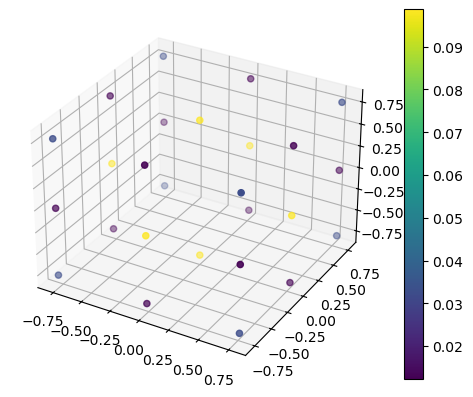

In [9]:
nodes, weights = recombination_cube_formula(3,5) # Gauss-Legendre reduced degree 5 formula in dimension 3
print("no. of nodes: ", len(weights))

no. of nodes:  21


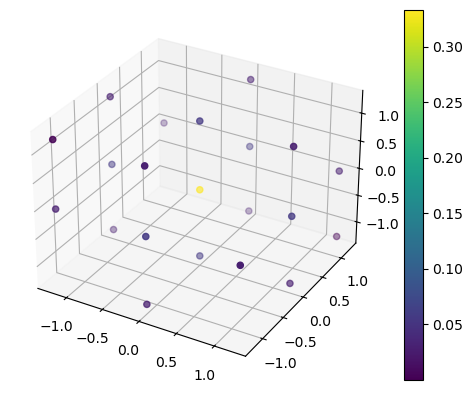

In [10]:
nodes, weights = recombination_cube_formula(3,5,'H') # Gauss-Hermite reduced degree 5 formula in dimension 3
print("no. of nodes: ", len(weights))

In [11]:
nodes, weights = recombination_cube_formula(6,7) # Gauss-Legendre reduced degree 7 formula in dimension 6
print("no. of nodes: ", len(weights))

no. of nodes:  956


The following function may be used to apply recombination to a cubature rule for an arbitrary domain to give a more efficient formula of desired degree.

In [20]:
def recombination_reduce(nodes : Float[Array, "n d"], weights : Float[Array, "n"], degree : int, show : bool = True):
    """
    Applies recombination to a cubature rule of arbitrary nodes and weights to give a formula of certain degre

    :param nodes: array of nodes to be reduced
    :param weights: corresponding weights of the nodes
    :param degree: the desired degree of the new formula
    :param show: for dimensions 2 and 3, will give diagram of the new cubature rule
    """
    product_cubature = Data(nodes, weights)
    powers = np.fromiter(
        monomial_power_generator(nodes.shape[1], degree, mode="all"),
        dtype=np.dtype((np.int32, dimension)),
    )

    test_functions = test_functions_from_monomial_powers(powers)
    test_functions_shape = jax.eval_shape(test_functions, jnp.zeros((dimension,)))
    
    if len(test_functions_shape) + 1 >= len(weights):
        raise ValueError('Insufficient number of points for formula of desired degree')

    solver = TreeRecombination(test_functions=test_functions, mode="explicit")
    coresubset_cubature, _ = solver.reduce(product_cubature)
    new_nodes, new_weights = coresubset_cubature.coreset.data, coresubset_cubature.coreset.weights
    
    if show == True:
        if nodes.shape[1] == 2:
            plt.scatter(new_nodes[:, 0], new_nodes[:, 1], c=new_weights)
            plt.colorbar()
        elif nodes.shape[1] == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            sc = ax.scatter(new_nodes[:,0], new_nodes[:,1], new_nodes[:,2], c=new_weights)
            cbar = plt.colorbar(sc, ax=ax)
        else:
            print('Dimension too large for visualisation')
            
    return new_nodes, new_weights